In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, classification_report, roc_curve
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.feature_selection import chi2, SelectKBest, f_classif, RFE
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
#from mlxtend.classifier import StackingClassifier
import scipy.stats as ss

In [2]:
train_path = r'C:\Users\Sau10\OneDrive\GreyAtom\Practice Dataset\greyatom_hackaton\train.csv'
test_path = r'C:\Users\Sau10\OneDrive\GreyAtom\Practice Dataset\greyatom_hackaton\test.csv'

In [3]:
df=pd.read_csv(train_path, index_col='ID')
df_test = pd.read_csv(test_path, index_col='ID')
df1=df
df.head(5)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
ID,,,,,,,,,,,
3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,NaN,31
4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,NaN,36
34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,NaN,75
55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,NaN,32
13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50553 entries, 3433 to 50880
Data columns (total 11 columns):
Agency                  50553 non-null object
Agency Type             50553 non-null object
Distribution Channel    50553 non-null object
Product Name            50553 non-null object
Claim                   50553 non-null int64
Duration                50553 non-null int64
Destination             50553 non-null object
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Gender                  14600 non-null object
Age                     50553 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.6+ MB


So, there are 4 numerical columns and 7 categorical columns

In [5]:
df['Gender'].isnull().sum()

35953

45107/63326 are null values, nearly 71.2% data in the column are null values.

Replacing the null values with another category called "Not Specified"

In [6]:
df.fillna('Not Specified',inplace=True)
df_test.fillna('Not Specified',inplace=True)

In [7]:
df.isnull().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Claim                   0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Gender                  0
Age                     0
dtype: int64

There is no null values now

First make an another dataframe which consist of only numerical columns from df

In [8]:
df_numerical=df._get_numeric_data()
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50553 entries, 3433 to 50880
Data columns (total 5 columns):
Claim                   50553 non-null int64
Duration                50553 non-null int64
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Age                     50553 non-null int64
dtypes: float64(2), int64(3)
memory usage: 2.3 MB


****Now lets look at the spread of the numerical data****

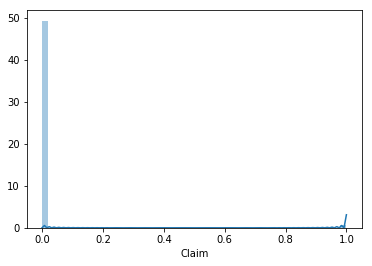

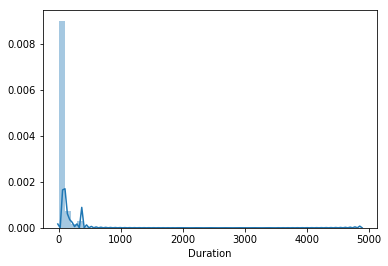

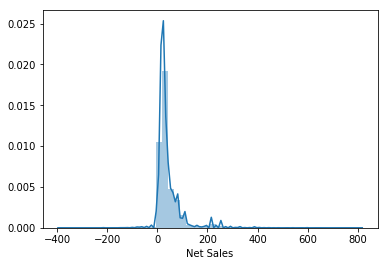

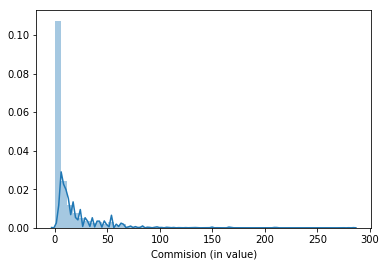

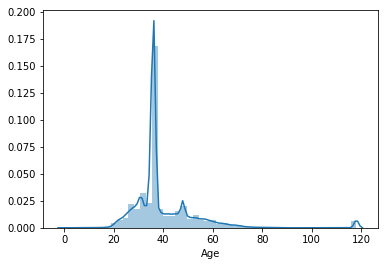

In [9]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(i)
    sns.distplot(df_numerical[col])

**From the graph we can conclude:**

*Duration*: Data in this column is highly right skewed.

*Net Sales and Commison*: These both column seems to related but the graph plot shows disparency as low net sales     shows high commison which is not pratically possible.

*Age*: Age is random so its distribution can be random.

**Lets check the data in "Duration" column**

In [10]:
df['Duration'].describe()

count    50553.000000
mean        49.425969
std        101.434647
min         -2.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

**Lets see how many negative values we have in Duration column**

In [11]:
df10=df['Duration']<0
df10.sum()

3

So, there are 3 negative values in Duration column. I am gonna replace those with the mean value

In [12]:
df.loc[df['Duration'] < 0, 'Duration'] = df['Duration'].mean()
df_test.loc[df_test['Duration'] < 0, 'Duration'] = df_test['Duration'].mean()

Previously we have checked that some columns have low Net Sales but High Commison but thats not possible

Lets see how many such columns we have here

In [13]:
df6= df['Net Sales']<df['Commision (in value)']
df6.sum()

1598

We gonna make all comission value 0 where net sales is 0.

In [14]:
df.loc[df['Net Sales'] == 0.0, 'Commision (in value)'] = 0
df_test.loc[df_test['Net Sales'] == 0.0, 'Commision (in value)'] = 0

In [15]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

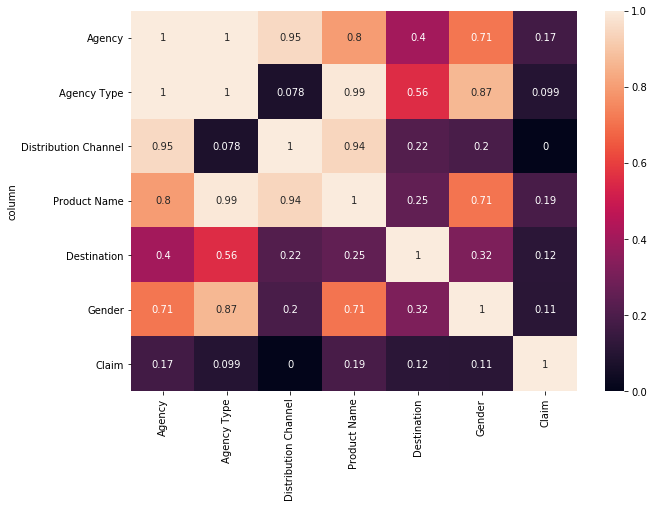

In [16]:
categorical=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',  'Destination','Gender','Claim']
cramers=pd.DataFrame({i:[cramers_v(df[i],df[j]) for j in categorical] for i in categorical})
cramers['column']=[i for i in categorical if i not in ['memberid']]
cramers.set_index('column',inplace=True)

#categorical correlation heatmap

plt.figure(figsize=(10,7))
sns.heatmap(cramers,annot=True)
plt.show()

**Observation:**

We can see the Co-relation between the Categorical columns.

Can coclude that the cloumn "Agency Type' have high corelation with some of the columns like "Agency","Product Name" thus we can drop "Agency Type".

**Lets Check how Gender is related to the Claim column**

In [17]:
test=[(df[df['Gender']=='Not Specified']['Claim'].value_counts()/len(df[df['Gender']=='Not Specified']['Claim']))[1],(df[df['Gender']=='M']['Claim'].value_counts()/len(df[df['Gender']=='M']['Claim']))[1],
      (df[df['Gender']=='F']['Claim'].value_counts()/len(df[df['Gender']=='F']['Claim']))[1]]
test

[0.006258170389119128, 0.031619503122093794, 0.03930439700268627]

**Observation :**
Female Gender have highest number of Claims approved. Though the numbers aren't that descriptive to conclude to a decision

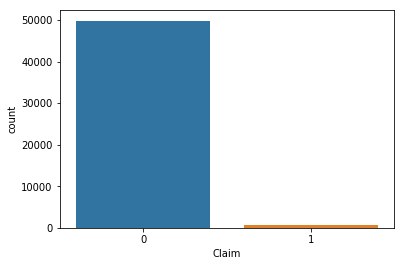

In [18]:
sns.countplot(df['Claim'])

From the above graph we can say that there is high imbalance in the target variable. We will see how to deal with that a little later

Removing highly correlated feature

In [19]:
df.drop(columns=['Distribution Channel','Agency Type'],axis=1,inplace=True)

In [20]:
df_test.drop(columns=['Distribution Channel','Agency Type'],axis=1,inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50553 entries, 3433 to 50880
Data columns (total 9 columns):
Agency                  50553 non-null object
Product Name            50553 non-null object
Claim                   50553 non-null int64
Duration                50553 non-null float64
Destination             50553 non-null object
Net Sales               50553 non-null float64
Commision (in value)    50553 non-null float64
Gender                  50553 non-null object
Age                     50553 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.4+ MB


In [22]:
y=df['Claim']

In [23]:
x=df
x.drop(columns='Claim',axis=1,inplace=True)

In [24]:
x_dummy=pd.get_dummies(x,columns=['Agency','Gender','Product Name','Destination'],drop_first=True)
x_dummy_test=pd.get_dummies(df_test,columns=['Agency','Gender','Product Name','Destination'],drop_first=True)

In [25]:
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=10, verbose=3)
rfe.fit(x_dummy, y)
rfe_df1 = rfe.fit_transform(x_dummy, y)

Fitting estimator with 146 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 145 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 144 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 143 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 142 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 141 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 140 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 139 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 138 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 137 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 136 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 135 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 134 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 133 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 132 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 131 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 130 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 129 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 128 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 127 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 126 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 125 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 124 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 123 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 122 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 121 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 120 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 119 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 118 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 117 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 116 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 115 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 114 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 113 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 112 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 111 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 110 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 109 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 108 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 107 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 106 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 105 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 104 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 103 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 102 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 101 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 100 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 99 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 98 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 97 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 96 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 95 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 94 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 93 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 92 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 91 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 90 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 89 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 88 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 87 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 86 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 85 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 84 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 83 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 82 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 81 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 80 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 79 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 78 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 77 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 76 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 75 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 74 features.
Fitting estimator with 73 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 72 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 71 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 70 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 69 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 68 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 67 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 66 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 65 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 64 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 63 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 62 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 61 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 60 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 59 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 58 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 57 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 56 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 55 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 54 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 53 features.
Fitting estimator with 52 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 51 features.
Fitting estimator with 50 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 49 features.
Fitting estimator with 48 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 47 features.
Fitting estimator with 46 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 45 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 44 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 43 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 42 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 40 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 39 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 38 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 37 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 36 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 35 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 34 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.
Fitting estimator with 32 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 31 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 30 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 29 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 28 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 27 features.
Fitting estimator with 26 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.
Fitting estimator with 24 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 23 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 22 features.
Fitting estimator with 21 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 20 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 19 features.
Fitting estimator with 18 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 17 features.
Fitting estimator with 16 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 15 features.
Fitting estimator with 14 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 13 features.
Fitting estimator with 12 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 11 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 146 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 145 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 144 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 143 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 142 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 141 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 140 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 139 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 138 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 137 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 136 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 135 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 134 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 133 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 132 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 131 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 130 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 129 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 128 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 127 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 126 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 125 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 124 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 123 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 122 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 121 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 120 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 119 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 118 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 117 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 116 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 115 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 114 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 113 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 112 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 111 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 110 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 109 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 108 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 107 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 106 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 105 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 104 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 103 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 102 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 101 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 100 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 99 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 98 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 97 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 96 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 95 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 94 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 93 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 92 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 91 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 90 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 89 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 88 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 87 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 86 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 85 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 84 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 83 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 82 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 81 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 80 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 79 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 78 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 77 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 76 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 75 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 74 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 73 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 72 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 71 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 70 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 69 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 68 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 67 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 66 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 65 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 64 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 63 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 62 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 61 features.
Fitting estimator with 60 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 59 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 58 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 57 features.
Fitting estimator with 56 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 55 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 54 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 53 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 52 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 51 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 50 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 49 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 48 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 47 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 46 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 45 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 44 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 43 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 42 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 40 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 39 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 38 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 37 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 36 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 35 features.
Fitting estimator with 34 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 32 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 31 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 30 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 29 features.
Fitting estimator with 28 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 27 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 26 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.
Fitting estimator with 24 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 23 features.
Fitting estimator with 22 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 21 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 20 features.
Fitting estimator with 19 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 18 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fitting estimator with 14 features.
Fitting estimator with 13 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 12 features.
Fitting estimator with 11 features.


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_dummy.columns)))

Features sorted by their rank:
[(1, 'Agency_EPX'), (1, 'Agency_TST'), (1, 'Destination_MYANMAR'), (1, 'Destination_NEPAL'), (1, 'Gender_Not Specified'), (1, 'Product Name_2 way Comprehensive Plan'), (1, 'Product Name_24 Protect'), (1, 'Product Name_Basic Plan'), (1, 'Product Name_Travel Cruise Protect'), (1, 'Product Name_Value Plan'), (2, 'Destination_ITALY'), (3, 'Destination_CZECH REPUBLIC'), (4, 'Product Name_Annual Travel Protect Gold'), (5, 'Product Name_Annual Silver Plan'), (6, 'Product Name_Annual Gold Plan'), (7, 'Agency_RAB'), (8, 'Destination_SRI LANKA'), (9, 'Destination_SOUTH AFRICA'), (10, 'Destination_SWITZERLAND'), (11, 'Product Name_Single Trip Travel Protect Platinum'), (12, 'Agency_C2B'), (13, 'Destination_INDIA'), (14, 'Agency_ART'), (15, 'Agency_JZI'), (16, 'Agency_TTW'), (17, 'Destination_SINGAPORE'), (18, 'Destination_MALAYSIA'), (19, 'Destination_PHILIPPINES'), (20, 'Destination_CAMBODIA'), (21, 'Product Name_Cancellation Plan'), (22, 'Product Name_Single Trip 

In [27]:
X=x_dummy[['Agency_EPX', 'Agency_TST', 'Destination_MYANMAR', 'Destination_NEPAL', 'Gender_Not Specified', 'Product Name_2 way Comprehensive Plan','Product Name_24 Protect','Product Name_Basic Plan', 'Product Name_Travel Cruise Protect','Product Name_Value Plan']]

In [28]:
X_val=x_dummy_test[['Agency_EPX', 'Agency_TST', 'Destination_MYANMAR', 'Destination_NEPAL', 'Gender_Not Specified', 'Product Name_2 way Comprehensive Plan','Product Name_24 Protect','Product Name_Basic Plan', 'Product Name_Travel Cruise Protect','Product Name_Value Plan']]

In [29]:
X.head(5)

,Agency_EPX,Agency_TST,Destination_MYANMAR,Destination_NEPAL,Gender_Not Specified,Product Name_2 way Comprehensive Plan,Product Name_24 Protect,Product Name_Basic Plan,Product Name_Travel Cruise Protect,Product Name_Value Plan
ID,,,,,,,,,,
3433,0,0,0,0,1,0,0,0,0,0
4339,1,0,0,0,1,0,0,0,0,0
34590,0,0,0,0,1,0,0,0,0,0
55816,1,0,0,0,1,1,0,0,0,0
13816,1,0,0,0,1,0,0,0,0,0


In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=7)
X_ov, y_ov = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_ov, y_ov, train_size=0.7, random_state=7)
pd.value_counts(y_train)

1    34935
0    34801
dtype: int64

In [31]:
def roc_auc_curve_plot_data(classifiers):
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])  

    for key, value in classifiers.items():
        yproba = value.predict_proba(X_test)[::,1] # to select probability estimates of the positive class

        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)

        result_table = result_table.append({'classifiers':key,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    return result_table

In [32]:
classifiers={}

In [33]:
def plot_roc_auc_curve(result_table) :
    fig = plt.figure(figsize=(8,6))

    #for loop to plot all the points on the curve
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    #plotting y = x line
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [34]:
def metric_data(y_true, y_pred):
    '''Method takes expected and actual output as parameters and provides all the relevant classification metrices'''
    #accuracy_score,classification_report,f1_score,confusion_matrix
    acc_score = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = f1_score(y_true, y_pred)
    prec_score = precision_score(y_true, y_pred)
    rec_score = recall_score(y_true, y_pred)
    roc_score = roc_auc_score(y_true, y_pred)
    classifn_report = classification_report(y_true, y_pred)
    print('Accuracy is ',acc_score)
    print('Precision Score is ', prec_score)
    print('F1 Score is ', f1)
    print('Recall Score is ', rec_score)
    print('Area under ROC Curve is ', roc_score)
    print('Confusion Matrix is ')
    print(tp, fp)
    print(fn, tn)
    print('Classification Report is ')
    print(classifn_report)


C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



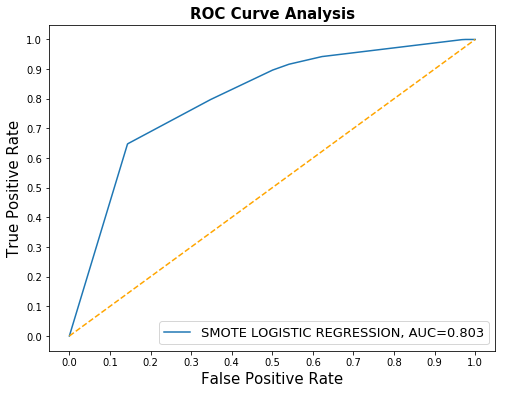

In [35]:
lr_model=lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
y_val_lr = lr.predict(X_val)

from sklearn.metrics import classification_report
metric_data(y_test, lr_pred)
classifiers['SMOTE LOGISTIC REGRESSION'] = lr_model
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

In [36]:
from sklearn.svm import LinearSVC
lsvc=LinearSVC()


svc_model=lsvc.fit(X_train,y_train)

lsvc_pred=lsvc.predict(X_test)
y_val_lsvc=lsvc.predict(X_val)

metric_data(y_test, lsvc_pred)

Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



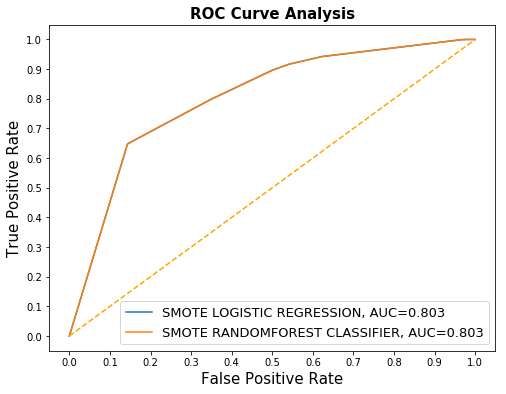

In [37]:
rfc=RandomForestClassifier(n_estimators=100)

rfc_model=rfc.fit(X_train,y_train)

rfc_pred=rfc.predict(X_test)

metric_data(y_test, rfc_pred)
classifiers['SMOTE RANDOMFOREST CLASSIFIER'] = rfc_model
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   12.2s finished
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



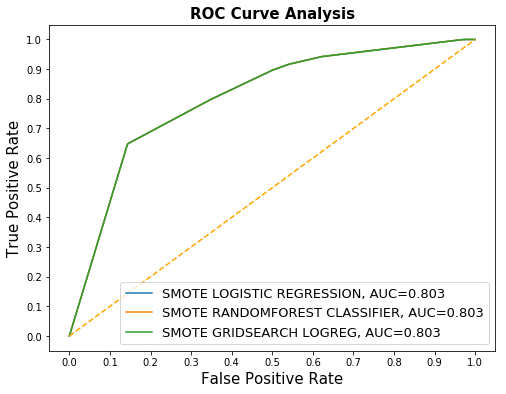

In [38]:
param_grid_logreg = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100]}

grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid=param_grid_logreg, cv=5, verbose=5, n_jobs=-1)

grid_search_log_reg.fit(X_train, y_train)

y_pred_logreg_gs = grid_search_log_reg.predict(X_test)

grid_search_log_reg.best_params_

metric_data(y_test, y_pred_logreg_gs)
classifiers['SMOTE GRIDSEARCH LOGREG'] = grid_search_log_reg
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



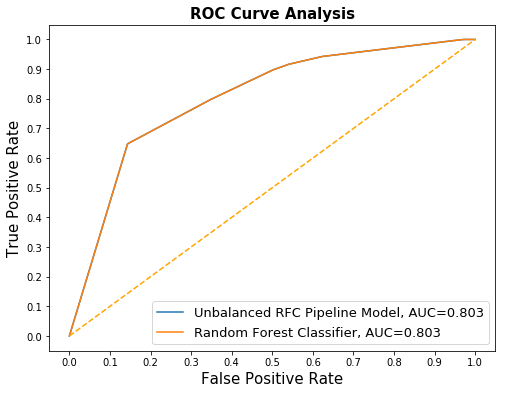

In [39]:
#using sklearn pipeline, a RFC on unbalanced dataset 
pipeline = make_pipeline(RandomForestClassifier(random_state=30))

rfc_pipeline_model = pipeline.fit(X_train, y_train)

y_pred_rfc_pipeline = rfc_pipeline_model.predict(X_test)

metric_data(y_test, y_pred_rfc_pipeline)

classifiers = {'Unbalanced RFC Pipeline Model': rfc_pipeline_model, 
                  'Random Forest Classifier' : rfc}

plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



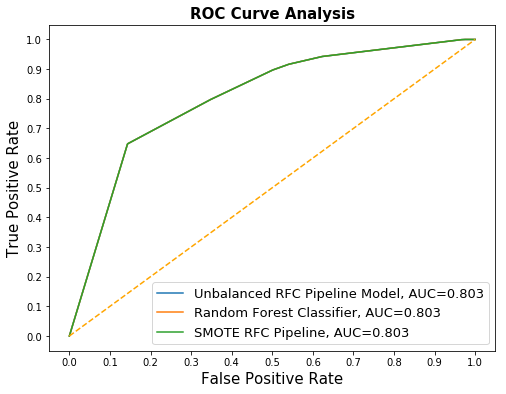

In [40]:
#model build using smote & RFC
smote_rfc_pipeline = make_pipeline_imb(SMOTE(random_state=30), RandomForestClassifier(random_state=30))

smote_rfc_pipeline_model = smote_rfc_pipeline.fit(X_train, y_train)

y_pred_smote_rfc_pipeline = smote_rfc_pipeline_model.predict(X_test)

metric_data(y_test, y_pred_smote_rfc_pipeline)

classifiers['SMOTE RFC Pipeline'] = smote_rfc_pipeline_model

plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



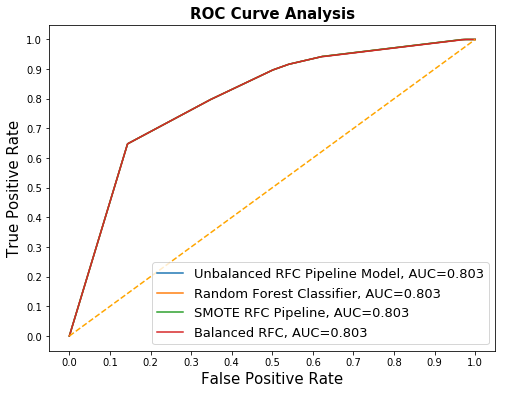

In [41]:
#Imblearn BalancedRandomForestClassifier
bal_rfc = BalancedRandomForestClassifier(max_depth=8, random_state=30)

bal_rfc_model = bal_rfc.fit(X_train, y_train)

y_pred_balance_rfc_model = bal_rfc_model.predict(X_test)

metric_data(y_test, y_pred_balance_rfc_model)

classifiers['Balanced RFC'] = bal_rfc_model
plot_roc_auc_curve(roc_auc_curve_plot_data(classifiers))

C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sau10\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy is  0.7526766595289079
Precision Score is  0.8170266836086404
F1 Score is  0.7229592984034181
Recall Score is  0.6483161927808025
Area under ROC Curve is  0.7522108576987752
Confusion Matrix is 
9645 2160
5232 12851
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     15011
           1       0.82      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



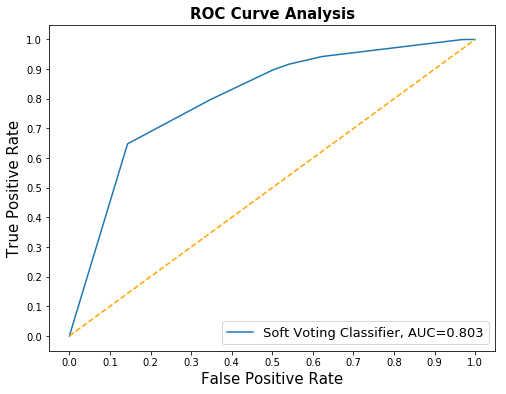

In [42]:
# Various models
log_reg_ensemble = LogisticRegression()
dt_ensemble = DecisionTreeClassifier(random_state=30)
rfc_ensemble = RandomForestClassifier(random_state=30)

model_list = [('log_reg_ensemble',log_reg_ensemble),('dt_ensemble',dt_ensemble),('rfc_ensemble',rfc_ensemble)]

# Code starts here
# Initialize voting classifier
voting_clf_soft = VotingClassifier(estimators=model_list,voting='soft')

# Fit the model on training data
voting_clf_soft.fit(X_train, y_train)

y_pred_soft_voting = voting_clf_soft.predict(X_test)

metric_data(y_test, y_pred_soft_voting)

ensembling_classifer = {'Soft Voting Classifier' : voting_clf_soft}

plot_roc_auc_curve(roc_auc_curve_plot_data(ensembling_classifer))

Accuracy is  0.7459180942184154
Precision Score is  0.8040410787342406
F1 Score is  0.7172115885901541
Recall Score is  0.647307924984876
Area under ROC Curve is  0.7454779582288978
Confusion Matrix is 
9630 2347
5247 12664
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.84      0.77     15011
           1       0.80      0.65      0.72     14877

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.74     29888
weighted avg       0.76      0.75      0.74     29888



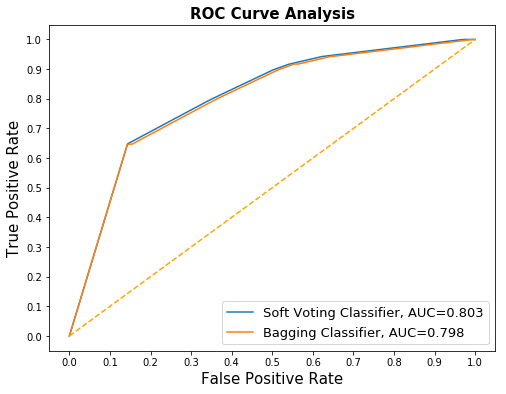

In [43]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), random_state=0,n_estimators=100,max_samples=100)

bagging_clf.fit(X_train, y_train)

y_pred_bagging_clf = bagging_clf.predict(X_test)

metric_data(y_test, y_pred_bagging_clf)

ensembling_classifer['Bagging Classifier'] = bagging_clf

plot_roc_auc_curve(roc_auc_curve_plot_data(ensembling_classifer))

In [44]:
for splits in [2, 5, 10, 15, 20] :
    kfold = KFold(n_splits=splits, random_state=30)
    for train, test in kfold.split(X_train, y_train):
        kfold_model = smote_rfc_pipeline.fit(X_train[train.ravel()], y_train[train.ravel()])
        y_pred_kfold = kfold_model.predict(X_train[test.ravel()])
        print('For Split of {}'.format(splits))
        metric_data(y_train[test.ravel()], y_pred_kfold)
        print('=='*25)

For Split of 2
Accuracy is  0.7526385224274407
Precision Score is  0.8165335635657242
F1 Score is  0.7246432334067618
Recall Score is  0.6513429752066116
Area under ROC Curve is  0.7525804534368302
Confusion Matrix is 
11349 2550
6075 14894
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.85      0.78     17444
           1       0.82      0.65      0.72     17424

    accuracy                           0.75     34868
   macro avg       0.76      0.75      0.75     34868
weighted avg       0.76      0.75      0.75     34868

For Split of 2
Accuracy is  0.7509751061144889
Precision Score is  0.8179657109926524
F1 Score is  0.7234096773165992
Recall Score is  0.6484495459996573
Area under ROC Curve is  0.7514299351822334
Confusion Matrix is 
11355 2527
6156 14830
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.85      0.77     17357
           1       0.82      0

For Split of 10
Accuracy is  0.7435823892155456
Precision Score is  0.8143013498723094
F1 Score is  0.7140115163147792
Recall Score is  0.6357163201367132
Area under ROC Curve is  0.7443457395022098
Confusion Matrix is 
2232 509
1279 2953
Classification Report is 
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      3462
           1       0.81      0.64      0.71      3511

    accuracy                           0.74      6973
   macro avg       0.76      0.74      0.74      6973
weighted avg       0.76      0.74      0.74      6973

For Split of 10
Accuracy is  0.75103972465223
Precision Score is  0.8144034396273737
F1 Score is  0.7236548869786692
Recall Score is  0.6511028358636494
Area under ROC Curve is  0.7511688791610033
Confusion Matrix is 
2273 518
1218 2964
Classification Report is 
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      3482
           1       0.81      0.65   

KeyboardInterrupt: 

In [ ]:
for top in [1,4,6,8,9] :
    kbest = SelectKBest(f_classif, k = top)
    X_train_new = kbest.fit_transform(X_train_res, y_train_res)
    X_test_new = kbest.transform(X_test)

    logreg2 = LogisticRegression(random_state=40)

    logreg2.fit(X_train, y_train)

    y_pred = logreg2.predict(X_test)

    # Calculate accuracy , print out the Classification report and Confusion Matrix.
    print("For k = {}, Accuracy is {}".format(top, accuracy_score(y_test, y_pred)))

    print("For k = {}, Classification Report is \n {}". format(top, classification_report(y_test, y_pred)))

    print("For k = {}, Confusion Matrix is {}".format(top, confusion_matrix(y_test, y_pred)))
    print('=='*50)

In [ ]:
classifiers.keys()

In [ ]:
y_val = pd.Series(y_val_lr)

In [ ]:
y_val.to_csv('test.csv')